values_array:  (256,)
bins_array:  (257,)
optimum threshold value = 95


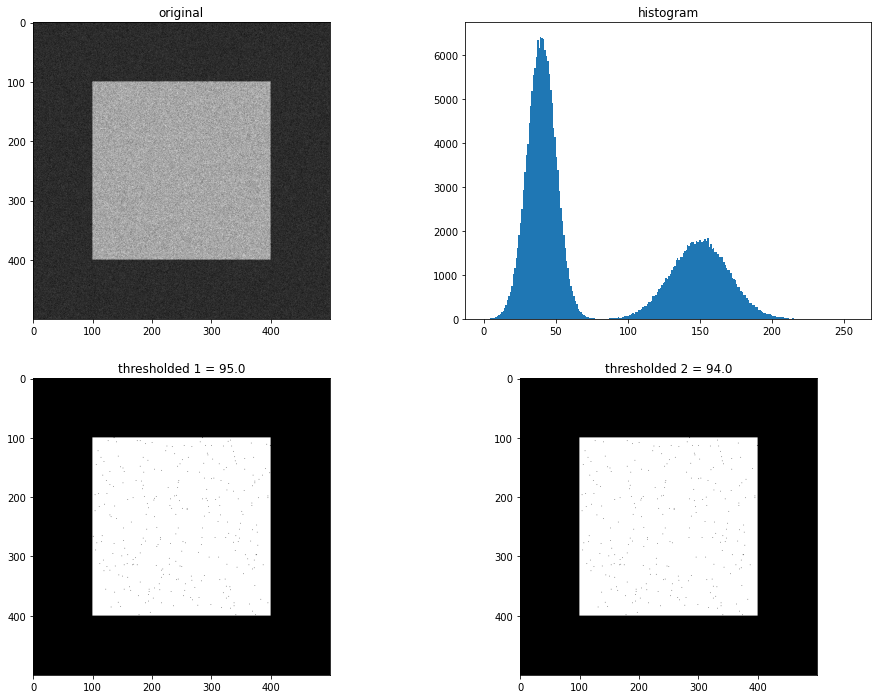

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a sample image
np.random.seed(7)
img = np.random.normal(40,10,size=(500,500)).astype('uint8')
img[img>100]=40
img[100:400,100:400] = np.random.normal(150,20,size=(300,300)).astype('uint8')
plt.subplot(2,2,1)
plt.title("original")
plt.imshow(img, cmap ='gray')

# plot the histogram
plt.subplot(2,2,2)
plt.title("histogram")
hist = plt.hist(img.ravel(), 256, [0,256])
values_array = hist[0]
bins_array = hist[1]
print("values_array: ", values_array.shape)
print("bins_array: ", bins_array.shape)

# Calculate the within-class variance
# Set minimum value to infinity
final_min = np.inf
# total pixels in an image
total = np.sum(hist[0])
for i in range(256):
    # Split regions based on threshold
    left, right = np.hsplit(hist[0],[i])
    # Splt intensity values based on threshold
    left_bins, right_bins = np.hsplit(hist[1],[i])
    # Only perform thresholding if neither side empty
    if np.sum(left) !=0 and np.sum(right) !=0:
        # Calculate weights on left and right sides
        w_0 = np.sum(left)/total
        w_1 = np.sum(right)/total
        # Calculate the mean for both sides
        mean_0 = np.dot(left,left_bins)/np.sum(left)
        mean_1 = np.dot(right,right_bins[:-1])/np.sum(right)  # right_bins[:-1] because matplotlib has uses 1 bin extra
        # Calculate variance of both sides
        var_0 = np.dot(((left_bins-mean_0)**2),left)/np.sum(left)
        var_1 = np.dot(((right_bins[:-1]-mean_1)**2),right)/np.sum(right)
        # Calculate final within class variance
        final = w_0*var_0 + w_1*var_1
        # if variance minimum, update it
        if final<final_min:
            final_min = final
            thresh = i
print("optimum threshold value = {}".format(thresh)) # 95
retval1, thresh1 = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
plt.subplot(2,2,3)
plt.title("thresholded 1 = {}".format(retval1))
plt.imshow(thresh1, cmap ='gray')

retval2, thresh2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(2,2,4)
plt.title("thresholded 2 = {}".format(retval2))
plt.imshow(thresh2, cmap ='gray')

plt.gcf().set_size_inches(16, 12)
plt.show()

maximum between-class variance = 2791.0577208153677
optimum threshold value = 94


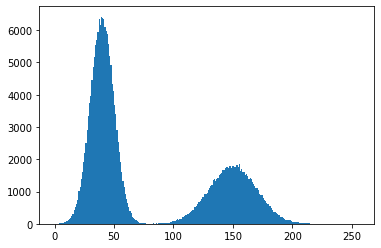

In [6]:
# Calculate the between-class variance
# Calculate the histogram
hist = plt.hist(img.ravel(), 256, [0,256])
# Total pixels in the image
total = np.sum(hist[0])
# calculate the initial weights and the means
left, right = np.hsplit(hist[0],[0])
left_bins, right_bins = np.hsplit(hist[1],[0])
# left weights
w_0 = 0.0
# Right weights
w_1 = np.sum(right)/total
# Left mean
weighted_sum_0 = 0.0
mean_0 = 0.0
# Right mean
weighted_sum_1 = np.dot(right,right_bins[:-1])
mean_1 = weighted_sum_1/np.sum(right)

def recursive_otsu1(hist, w_0=w_0, w_1=w_1, weighted_sum_0=weighted_sum_0, weighted_sum_1=weighted_sum_1, \
                    thres=1, fn_max=-np.inf, thresh=0, total=total):
    if thres<=255:
        # To pass the division by zero warning
        if np.sum(hist[0][:thres+1]) !=0 and np.sum(hist[0][thres+1:]) !=0:
            # Update the weights
            w_0 += hist[0][thres]/total
            w_1 -= hist[0][thres]/total
            # Update the mean
            weighted_sum_0 += (hist[0][thres]*hist[1][thres])
            mean_0 = weighted_sum_0/np.sum(hist[0][:thres+1])
            weighted_sum_1 -= (hist[0][thres]*hist[1][thres])
            if thres == 255:
                mean_1 = 0.0
            else:
                mean_1 = weighted_sum_1/np.sum(hist[0][thres+1:])
            # Calculate the between-class variance
            out = w_0*w_1*((mean_0-mean_1)**2)
            # # if variance maximum, update it
            if out>fn_max:
                fn_max = out
                thresh = thres
        return recursive_otsu1(hist, w_0=w_0, w_1=w_1, weighted_sum_0=weighted_sum_0, \
                               weighted_sum_1=weighted_sum_1, thres=thres+1, fn_max=fn_max, \
                               thresh=thresh, total=total)
    # Stopping condition
    else:
        return fn_max,thresh
    
    
# Check the results
var_value, thresh_value = recursive_otsu1(hist, w_0=w_0, w_1=w_1, weighted_sum_0=weighted_sum_0, \
                                          weighted_sum_1=weighted_sum_1, thres=1, fn_max=-np.inf, \
                                          thresh=0, total=total)

print("maximum between-class variance = {}".format(var_value))
print("optimum threshold value = {}".format(thresh_value))